In [1]:
from time import sleep

import numpy as np
import xarray as xr
from simulation_tutorial import xarray_mods as xrmod


Put all your simulation code in functions, preferably in a separate .py file and import it as a module.

In [2]:
# Example of simulation function
def kinetic_energy_j(m_kg, v_m_per_s):
    return .5 * m_kg * v_m_per_s ** 2

The trick is now to use a dataset from xarray to store your parameters and simulation results.
Function calls can be executed with xr.apply_ufunc
This might feel like an unnecessary complication of the problem, it will prove to be a very powerful and flexible framework of running sweeps of simulations.

In [3]:
ds = xr.Dataset()
ds['m'] = 3
ds['v'] = 5
ds['E_kin'] = xr.apply_ufunc(kinetic_energy_j, ds.m, ds.v)
ds

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    m        int64 8B 3
    v        int64 8B 5
    E_kin    float64 8B 37.5

Say we want to see what the effect is of sweeping a.

In [4]:
ds = xr.Dataset()
ds['m'] = 5
ds['v'] = np.linspace(0,10)
ds['E_kin'] = xr.apply_ufunc(kinetic_energy_j, ds.m, ds.v)
ds

<xarray.Dataset> Size: 808B
Dimensions:  (v: 50)
Coordinates:
  * v        (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m        int64 8B 5
    E_kin    (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0

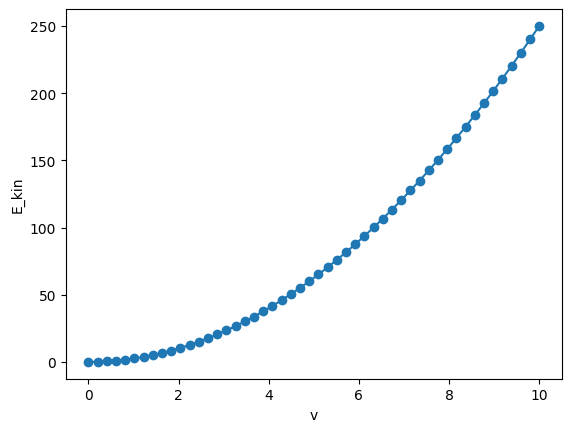

In [5]:
ds.E_kin.plot(marker='o')

Let's start adding labels and units so that the plotting is directly correct.\
'long_name' and 'units' are special attributes of DataArrays.\
Notice that most methods of xarray return a new object rather than modify the old one in place.\
This facilitates chaining of operations in a single line, but pay attention to assign the outcome again.

In [6]:
ds = xr.Dataset()
ds['m'] = 5
ds['m'] = ds.m.assign_attrs(long_name="mass", units="kg")
ds['v'] = np.linspace(0,10)
ds['v'] = ds.v.assign_attrs(long_name="velocity", units="m/s")
ds['E_kin'] = xr.apply_ufunc(kinetic_energy_j, ds.m, ds.v, keep_attrs=True)
ds['E_kin'] = ds.E_kin.assign_attrs(long_name="Kinetic energy", units="J")
ds

<xarray.Dataset> Size: 808B
Dimensions:  (v: 50)
Coordinates:
  * v        (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m        int64 8B 5
    E_kin    (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0

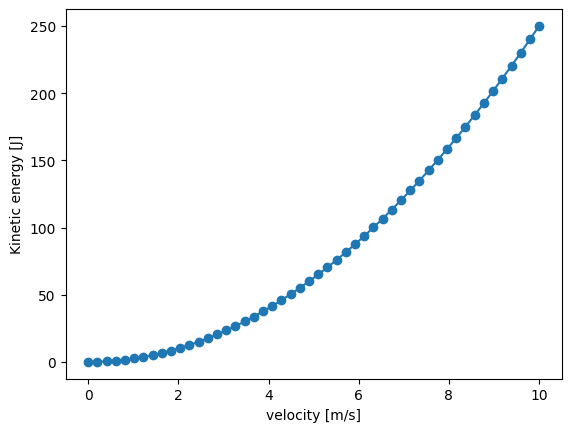

In [7]:
ds.E_kin.plot(marker='o')

Say we would like to vary both a and b independently.

In [8]:
ds = xr.Dataset()
ds['m'] = np.linspace(3,17)
ds['m'] = ds.m.assign_attrs(long_name="mass", units="kg")
ds['v'] = np.linspace(0,10)
ds['v'] = ds.v.assign_attrs(long_name="velocity", units="m/s")
ds['E_kin'] = xr.apply_ufunc(kinetic_energy_j, ds.m, ds.v, keep_attrs=True)
ds['E_kin'] = ds.E_kin.assign_attrs(long_name="Kinetic energy", units="J")
ds

<xarray.Dataset> Size: 21kB
Dimensions:  (m: 50, v: 50)
Coordinates:
  * m        (m) float64 400B 3.0 3.286 3.571 3.857 ... 16.14 16.43 16.71 17.0
  * v        (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    E_kin    (m, v) float64 20kB 0.0 0.06247 0.2499 0.5623 ... 782.0 815.7 850.0

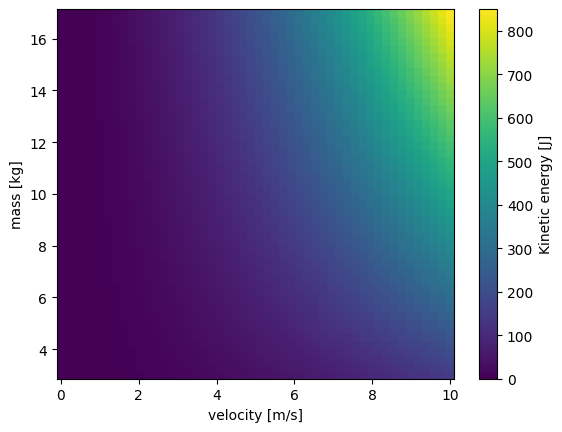

In [9]:
ds.E_kin.plot()

Note that the plotting also got the axis correct by labeling them with the values of a and b.

If you want to vary a and b together you have to give them the same dimension, for example 'index'.

In [10]:
ds = xr.Dataset()
ds['m'] = xr.DataArray(np.linspace(3,17), dims='index')
ds['m'] = ds.m.assign_attrs(long_name="mass", units="kg")
ds['v'] = xr.DataArray(np.linspace(0,10), dims='index')
ds['v'] = ds.v.assign_attrs(long_name="velocity", units="m/s")
ds['E_kin'] = xr.apply_ufunc(kinetic_energy_j, ds.m, ds.v, keep_attrs=True)
ds['E_kin'] = ds.E_kin.assign_attrs(long_name="Kinetic energy", units="J")
ds

<xarray.Dataset> Size: 1kB
Dimensions:  (index: 50)
Dimensions without coordinates: index
Data variables:
    m        (index) float64 400B 3.0 3.286 3.571 3.857 ... 16.43 16.71 17.0
    v        (index) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
    E_kin    (index) float64 400B 0.0 0.06842 0.2975 ... 755.7 802.0 850.0

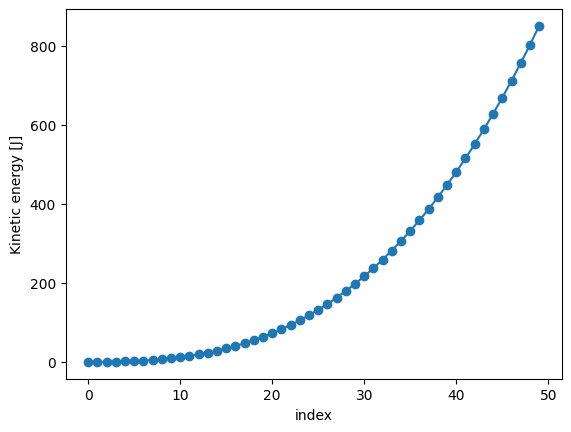

In [11]:
ds.E_kin.plot(marker='o')

# Vectorized sweeping

In [12]:
from time import sleep

Say you have a function that can't compute with numpy arrays but needs individual runs for each simulation point.
For example this is the case for QuTip simulations.
We imitate this with the assert in the function below. On top of this we do as if this computation is complex and requires some calculation time to show the benefit of multiprocessing.

In [13]:
def kinetic_energy_slow_j(m_kg, v_m_per_s):
    assert isinstance(v_m_per_s, (int, float, np.integer, np.floating))
    sleep(.05)
    return .5 * m_kg * v_m_per_s ** 2

To be able to sweep this function we need to vectorize it in apply_ufunc.
Note, it is almost always faster to execute to have functions that can handle numpy arrays as opposed to using vectorize.
Vectorize is just a fancy for loop.

In [14]:
ds = xr.Dataset()
ds['m'] = 5
ds['v'] = np.linspace(0,10)
ds['E_kin'] = xr.apply_ufunc(kinetic_energy_slow_j, ds.m, ds.v, vectorize=True)
ds


<xarray.Dataset> Size: 808B
Dimensions:  (v: 50)
Coordinates:
  * v        (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m        int64 8B 5
    E_kin    (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0

To speed this up we can use the wrapper I have written that can do multiprocessing.
It adds a keyword argument of multiprocessing and this can be used if vectorize is also used.

In [15]:
ds = xr.Dataset()
ds['m'] = 5
ds['v'] = np.linspace(0,10)
ds['E_kin'] = xrmod.apply_ufunc(kinetic_energy_slow_j, ds.m, ds.v, vectorize=True, multiprocessing=True)
ds

100%|██████████| 50/50 [00:00<00:00, 155.69it/s]


<xarray.Dataset> Size: 808B
Dimensions:  (v: 50)
Coordinates:
  * v        (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m        int64 8B 5
    E_kin    (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0

You can see that this speeds up the calculation.

# More complex function calls

If your function returns multiple arguments than you can use core_output_dims to define those.
As usually the return values don't have an internal array structure you have to give empty lists.

In [16]:
def kinetic_energy_and_momentum(m_kg, v_m_per_s):
    energy = .5 * m_kg * v_m_per_s ** 2
    momentum = m_kg * v_m_per_s
    return energy, momentum

In [17]:
ds = xr.Dataset()
ds['m'] = 5
ds['v'] = np.linspace(0,10)
ds['E_kin'], ds['momentum'] = xr.apply_ufunc(kinetic_energy_and_momentum, ds.m, ds.v, output_core_dims=[[],[]])
ds

<xarray.Dataset> Size: 1kB
Dimensions:   (v: 50)
Coordinates:
  * v         (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m         int64 8B 5
    E_kin     (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0
    momentum  (v) float64 400B 0.0 1.02 2.041 3.061 ... 46.94 47.96 48.98 50.0

This is also possible with multiprocessing.

If you get errors that input or output dimensions are not as expected have a look at output_core_dims and input_core_dims, these are usually where to properly define what your function expects (input) and what it gets back (output).